# 高斯过程回归

假设一组n个观测值，每个观测值为D维向量 $X = x_1, \dots, x_n $, 对应的值为n个1维目标向量 $Y = y_1, \dots, y_n$.

假设回归残差 $\epsilon = [\epsilon_1, \dots, \epsilon_n]$ 服从正态分布 $p(\epsilon) = \mathcal{N}(0, \sigma_{noise}^2)$

因此回归问题就是希望通过X，Y学习一个由X到Y的映射函数f

$$
Y = \mathcal{f}(X) + \epsilon, \quad where \quad \epsilon_i \thicksim \mathcal{N}(0, \sigma_{noise}^2), i=1, \dots, n
$$

未知映射f遵循高斯过程，通过 $\mu = [\mu(x_1), \dots, \mu(x_n)]$ 与 $k(x_i, x_j)$定义一个高斯过程。

在拟合之前，我们需要一个先验。

$$
\mathcal{f}(X) \thicksim \mathcal{GP}[\mu, K(X, X)]
$$

高斯过程由其数学期望 $\mu$ 和协方差函数K完全决定。

## 贝叶斯定理

高斯过程按照贝叶斯方法通过学习样本确定核函数的超参数 $\theta$的过程。其中使用最多的核函数是RBF（径向基函数）核。

$$
p(\theta | X, Y) = \frac{p(Y|X, \theta)p(\theta)}{p(Y|X)}
$$

其中 $\theta$ 包括核函数的超参数和残差的方差 $\sigma_{noise}^2$

其中 $p(Y|X, \theta)$ 是似然，是对高斯过程回归的输出边缘化得到的边缘似然。

$$
p(Y|X, \theta) = \int p(Y|\mathcal{f}, X, \theta) p(\mathcal{f}|X, \theta) d\mathcal{f}
$$

高斯分布的边缘分布仍然是高斯分布，因此边缘似然也服从高斯分布，则概率可写为：

$$
P(Y|X, \theta) =  \frac{1}{(2\pi)^{k/2} |\Sigma|^{1/2}} exp(-\frac{1}{2}(X - \mu(X))^T\Sigma^{-1}(X-\mu(X)))
$$

一般情况下，我们都会对数据集的输出进行标准化处理来达到去均值的目的，这样做的好处就是我们只需要设置 $\mu = 0$ 即可

因此，负对数似然函数为：

$$
L = -lnp(Y|X, \theta)
= -[-\frac{1}{2}ln|\Sigma| - \frac{n}{2}ln(2\pi)-\frac{1}{2}(Y-\mu(X))^T\Sigma^{-1}(Y-\mu(x))] \\[4mm]
= \frac{1}{2}ln|\Sigma| + \frac{n}{2}ln(2\pi)+\frac{1}{2}Y^T\Sigma^{-1}Y (\mu=0)
$$

其中， $\Sigma = k(X, X) + \sigma_{noise}^2I$ 与参数 $\theta$有关。利用梯度下降法来更新超参数。

### 先验

$x_2$ 为一系列需要预测的点，$y_2 = GP(x_2)$ 对应高斯过程预测结果。

高斯过程的先验为：

$$
y_2 \thicksim N(\mu_2, K_{22})
$$

其中，$\mu_2$ 为高斯过程的均值，$K_{22}$为协方差矩阵。高斯过程的协方差矩阵通过核函数定义。

sklearn中，高斯核定义为：

$$
k(x_i, x_j) = exp\left(-\frac{(x_i - x_j)^2}{2l^2}\right)
$$

### 联合分布

假设样本数据 $y_i$ 和预测值 $y_2$ 服从联合高斯分布：
$$
\begin{bmatrix}
y_1 \\ 
y_2
\end{bmatrix}
\sim \mathcal{N}\left( 
\begin{bmatrix}
\mu_1 \\ 
\mu_2
\end{bmatrix},
\begin{bmatrix}
K_{11} & K_{12} \\ 
K_{21} & K_{22}
\end{bmatrix}
\right),
$$

简单来说，高斯过程对应的分布可以看成是无限多个随机变量的联合分布。

![image.png](./assert/image.png)

联合分布中的协方差矩阵直接编码了“似然”和“先验”的关系，而不需要显式去写 $p(D|\theta)p(\theta)$

### 后验

在联合概率分布已知的情况下，推导后验分布：
$$
p(y_2|y_1,X_1, X_2)
$$

有了联合概率分布$p(y_2, y_1 | X_1, X_2)$，那么如果除以边缘概率分布$p(y_1|X_1, X_2)$，就可以得到后验了。

但是由于我们在操作过程中，使用的都是正态分布，因此，不需要这么麻烦，直接使用多元高斯的条件概率公式即可：

---

**高斯分布的条件分布公式**

对于多元高斯分布：
$$
\begin{bmatrix}
z_1 \\ 
z_2
\end{bmatrix}
\sim \mathcal{N}\left( 
\begin{bmatrix}
\mu_1 \\ 
\mu_2
\end{bmatrix},
\begin{bmatrix}
\Sigma_{11} & \Sigma_{12} \\ 
\Sigma_{21} & \Sigma_{22}
\end{bmatrix}
\right),
$$

条件分布 $ p(z_2 \mid z_1) $ 仍然是高斯分布：
$$
z_2 \mid z_1 \sim \mathcal{N}\left(\mu_{z_2 \mid z_1}, \Sigma_{z_2 \mid z_1}\right),
$$
其中：
- 条件均值：
  $$
  \mu_{z_2 \mid z_1} = \mu_2 + \Sigma_{21} \Sigma_{11}^{-1} (z_1 - \mu_1),
  $$
- 条件协方差：
  $$
  \Sigma_{z_2 \mid z_1} = \Sigma_{22} - \Sigma_{21} \Sigma_{11}^{-1} \Sigma_{12}.
  $$

---


利用贝叶斯定理，我们可以整个先验分布和样本数据获得后验分布为：

$$
\mathcal{f}(y_2|y_1) \thicksim N\left( K_{21}K_{11}^{-1}(y_1-\mu_1)+\mu_2, K_{22}-K_{21}K_{11}^{-1}K_{12}\right)
$$

画图时，每个点对应的标准差为：

$$
sqrt(diag(K_{22}-K_{21}K_{11}^{-1}K_{12}))
$$

**普通贝叶斯需要乘，因为没有“结构”**

一般来说，贝叶斯公式 $ p(\theta \mid D) \propto p(D \mid \theta)p(\theta) $ 是因为似然 $ p(D \mid \theta) $ 和先验 $ p(\theta) $ 是独立建模的，你必须手动乘起来才能得到联合分布。

而高斯过程不用手动乘，是因为：
1. 它直接从联合分布出发建模。
2. 联合分布的条件分布公式直接完成了“乘法 + 归一化”。

高斯过程是一种基于概率论的非参数模型，可以用于建模连续函数或实数值变量的概率分布。在高斯过程中，先验分布通过核函数和一些超参数来定义，数据点的观测可以通过似然函数与先验分布相结合，计算后验分布。高斯过程中的核函数通常定义了数据点之间的相似性，超参数可以通过最大化似然或最大化边缘似然来优化。

在回归问题中，高斯过程可以用于预测连续变量的值，并估计预测值的不确定性。

### 参考

https://sirlis.cn/posts/deep-learning-gaussian-process/

https://github.com/Visualize-ML/Book7_Visualizations-for-Machine-Learning/blob/main/Book7_Ch07_%E9%AB%98%E6%96%AF%E8%BF%87%E7%A8%8B__%E6%9C%BA%E5%99%A8%E5%AD%A6%E4%B9%A0__%E9%B8%A2%E5%B0%BE%E8%8A%B1%E4%B9%A6__%E4%BB%8E%E5%8A%A0%E5%87%8F%E4%B9%98%E9%99%A4%E5%88%B0%E6%9C%BA%E5%99%A8%E5%AD%A6%E4%B9%A0.pdf



(8, 1) (8,)


/opt/anaconda3/envs/pythonTry/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


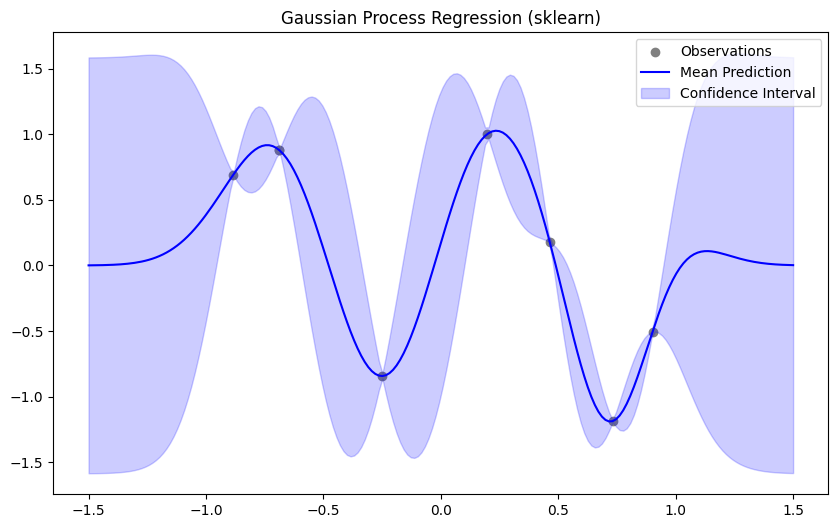

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel


# 数据生成
np.random.seed(42)
X = np.random.uniform(-1, 1, 8).reshape(-1, 1)
y = np.sin(2 * np.pi * X).ravel() + np.random.normal(0, 0.1, X.shape[0])
print(X.shape, y.shape)

# 核函数
kernel = ConstantKernel(1.0, (0.1, 10.0)) * RBF(length_scale=1.0, length_scale_bounds=(0.1, 10.0)) + WhiteKernel(noise_level=0.1)
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

# 模型拟合
gpr.fit(X, y)

# 预测
X_pred = np.linspace(-1.5, 1.5, 200).reshape(-1, 1)
y_pred, y_std = gpr.predict(X_pred, return_std=True)

# 可视化
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color="gray", label="Observations")
plt.plot(X_pred, y_pred, color="blue", label="Mean Prediction")
plt.fill_between(X_pred.ravel(), y_pred - 2 * y_std, y_pred + 2 * y_std, alpha=0.2, color="blue", label="Confidence Interval")
plt.legend()
plt.title("Gaussian Process Regression (sklearn)")
plt.show()


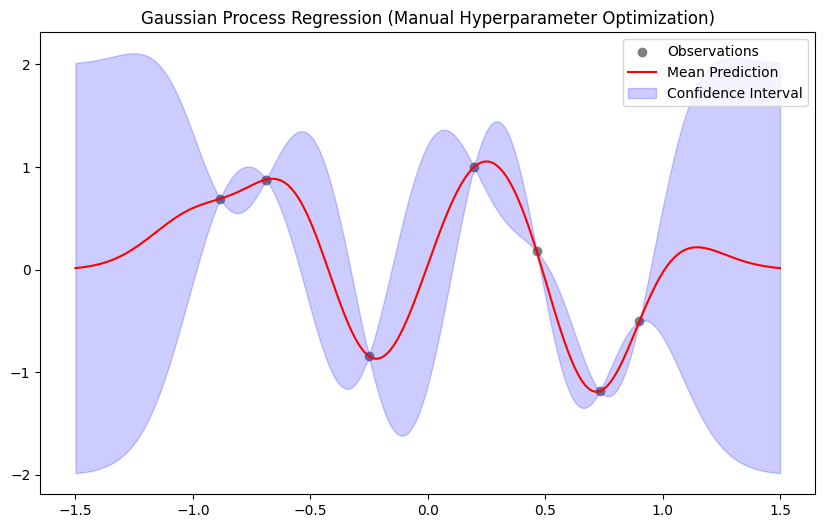

In [2]:
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt

# 自定义高斯过程
class GaussianProcess:
    def __init__(self):
        # 优化超参数, 通过极大似然估计的方式找到优化的超参数。
        initial_params = [1.0, 0.1]  # 初始 length_scale 和 sigma_n
        bounds = [(0.1, 10), (1e-5, 1)]  # 超参数的范围
        result = minimize(self.log_marginal_likelihood, initial_params, args=(X, y), bounds=bounds)
        self.length_scale_opt, self.sigma_n_opt = result.x

    # 定义边际对数似然函数 L
    def log_marginal_likelihood(self, params, X, y):
        length_scale, sigma_n = params
        K = self.rbf_kernel(X, X, length_scale) + sigma_n**2 * np.eye(len(X))
        K_inv = np.linalg.inv(K)
        LML = -0.5 * y.T @ K_inv @ y - 0.5 * np.log(np.linalg.det(K)) - 0.5 * len(X) * np.log(2 * np.pi)
        return -LML  # 取负数，方便最小化
    
    # 定义核函数
    def rbf_kernel(self, X1, X2, length_scale):
        sqdist = np.sum(X1**2, axis=1).reshape(-1, 1) + np.sum(X2**2, axis=1) - 2 * np.dot(X1, X2.T)
        return np.exp(-0.5 / length_scale**2 * sqdist)

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        self.K = self.rbf_kernel(X, X, self.length_scale_opt) + self.sigma_n_opt**2 * np.eye(len(X))
        self.K_inv = np.linalg.inv(self.K)

    def predict(self, X_pred):
        K_s = self.rbf_kernel(self.X_train, X_pred, self.length_scale_opt) #K12
        K_ss = self.rbf_kernel(X_pred, X_pred, self.length_scale_opt) # K22
        mu = K_s.T @ self.K_inv @ self.y_train
        cov = K_ss - K_s.T @ self.K_inv @ K_s
        return mu, np.sqrt(np.maximum(np.diag(cov), 0))

gp = GaussianProcess()
gp.fit(X, y)

# 预测
mu, std = gp.predict(X_pred)

# 可视化结果
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color="gray", label="Observations")
plt.plot(X_pred, mu, color="red", label="Mean Prediction")
plt.fill_between(
    X_pred.ravel(),
    mu - 2 * std,
    mu + 2 * std,
    alpha=0.2,
    color="blue",
    label="Confidence Interval"
)
plt.legend()
plt.title("Gaussian Process Regression (Manual Hyperparameter Optimization)")
plt.show()


## 试一下用自己写的高斯过程跑一下detrending

In [3]:
import lightkurve as lk

quarters = range(5, 6) 
cadence = 'long'
quality_bitmask = 'hard'

lc = lk.search_lightcurve('7678434', quarter=5, cadence='long').download()
lc

/opt/anaconda3/envs/pythonTry/lib/python3.11/site-packages/lightkurve/search.py:424: LightkurveWarning: Warning: 2 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


time,flux,flux_err,quality,timecorr,centroid_col,centroid_row,cadenceno,sap_flux,sap_flux_err,sap_bkg,sap_bkg_err,pdcsap_flux,pdcsap_flux_err,sap_quality,psf_centr1,psf_centr1_err,psf_centr2,psf_centr2_err,mom_centr1,mom_centr1_err,mom_centr2,mom_centr2_err,pos_corr1,pos_corr2
,electron / s,electron / s,,d,pix,pix,,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,,pix,pix,pix,pix,pix,pix,pix,pix,pix,pix
Time,float32,float32,int32,float32,float64,float64,int32,float32,float32,float32,float32,float32,float32,int32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32
443.49027036663756,———,———,10000,-8.845534e-04,398.89475,315.34347,16373,9.9525410e+03,3.5273221e+00,1.0370768e+03,2.4227034e-01,———,———,10000,———,———,———,———,398.89475,5.5511191e-04,315.34347,4.5122061e-04,-9.3653398e-03,-9.4460715e-03
443.5107047278798,1.2531658e+04,4.4004393e+00,10000,-8.838921e-04,398.89572,315.34261,16374,9.9466250e+03,3.5268369e+00,1.0373975e+03,2.4222079e-01,1.2531658e+04,4.4004393e+00,10000,———,———,———,———,398.89572,5.5535283e-04,315.34261,4.5136959e-04,-8.8174473e-03,-9.4308667e-03
443.5311388893533,1.2534514e+04,4.4019165e+00,10000,-8.832306e-04,398.89530,315.34385,16375,9.9478457e+03,3.5268395e+00,1.0371053e+03,2.4193905e-01,1.2534514e+04,4.4019165e+00,10000,———,———,———,———,398.89530,5.5514369e-04,315.34385,4.5127125e-04,-9.1328574e-03,-9.2239259e-03
443.55157315099495,1.2539969e+04,4.4012403e+00,10000,-8.825690e-04,398.89533,315.34396,16376,9.9512344e+03,3.5272257e+00,1.0361233e+03,2.4208289e-01,1.2539969e+04,4.4012403e+00,10000,———,———,———,———,398.89533,5.5569038e-04,315.34396,4.5165422e-04,-8.9045381e-03,-9.2422357e-03
443.57200751281925,1.2540621e+04,4.4024835e+00,10000,-8.819072e-04,398.89533,315.34323,16377,9.9515303e+03,3.5272193e+00,1.0369625e+03,2.4192330e-01,1.2540621e+04,4.4024835e+00,10000,———,———,———,———,398.89533,5.5508834e-04,315.34323,4.5113772e-04,-8.4050428e-03,-9.3483757e-03
443.59244167487486,1.2536798e+04,4.4017591e+00,10000,-8.812451e-04,398.89695,315.34355,16378,9.9476582e+03,3.5268722e+00,1.0364393e+03,2.4228883e-01,1.2536798e+04,4.4017591e+00,10000,———,———,———,———,398.89695,5.5517867e-04,315.34355,4.5123810e-04,-7.9977438e-03,-9.5835626e-03
443.61287593704037,1.2529871e+04,4.4018140e+00,10000,-8.805830e-04,398.89590,315.34504,16379,9.9409990e+03,3.5262201e+00,1.0364730e+03,2.4190800e-01,1.2529871e+04,4.4018140e+00,10000,———,———,———,———,398.89590,5.5555586e-04,315.34504,4.5157375e-04,-8.0359150e-03,-9.7972695e-03
443.63331029950496,1.2526103e+04,4.4019012e+00,10000,-8.799205e-04,398.89577,315.34316,16380,9.9379775e+03,3.5259254e+00,1.0375664e+03,2.4216802e-01,1.2526103e+04,4.4019012e+00,10000,———,———,———,———,398.89577,5.5568374e-04,315.34316,4.5167547e-04,-8.1865629e-03,-1.0065889e-02


(200, 1) (200,)


/var/folders/jx/hsm21jg10x574b3w9kt9p29w0000gn/T/ipykernel_14767/2686942411.py:19: RuntimeWarning: divide by zero encountered in log
  LML = -0.5 * y.T @ K_inv @ y - 0.5 * np.log(np.linalg.det(K)) - 0.5 * len(X) * np.log(2 * np.pi)
/opt/anaconda3/envs/pythonTry/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


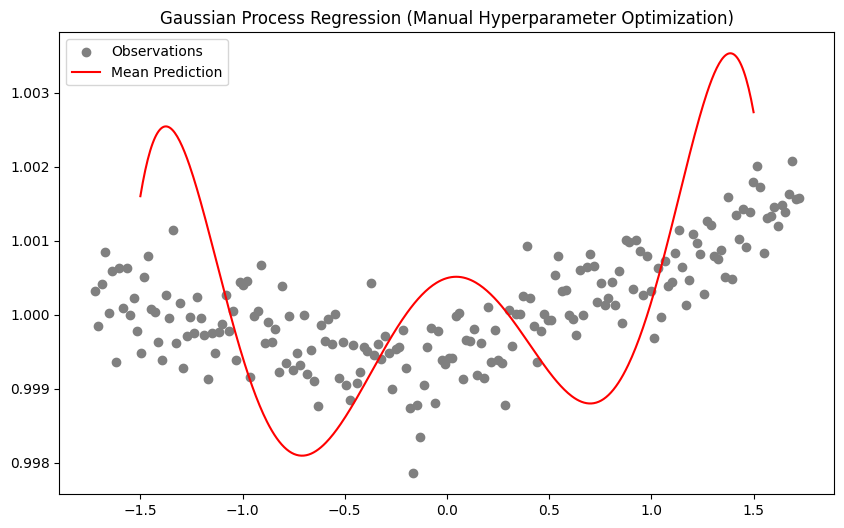

((200, 1), (200,))

In [11]:
from sklearn.preprocessing import StandardScaler
flux_value = lc.flux[2300: 2500]

X = np.arange(0, len(flux_value)).reshape(-1, 1)
y = flux_value / np.nanmedian(flux_value)
y[np.isnan(y)] = 1
print(X.shape, y.shape)

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_pred = np.linspace(-1.5, 1.5, 500).reshape(-1, 1)


gp = GaussianProcess()
gp.fit(X, y)

# 预测
mu, std = gp.predict(X_pred)

# 可视化结果
plt.figure(figsize=(10, 6))
cut = slice(None, None)
plt.scatter(X[cut], y[cut], color="gray", label="Observations")
plt.plot(X_pred[cut], mu[cut], color="red", label="Mean Prediction")
plt.legend()
plt.title("Gaussian Process Regression (Manual Hyperparameter Optimization)")
plt.show()

X.shape, y.shape

/opt/anaconda3/envs/pythonTry/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/anaconda3/envs/pythonTry/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


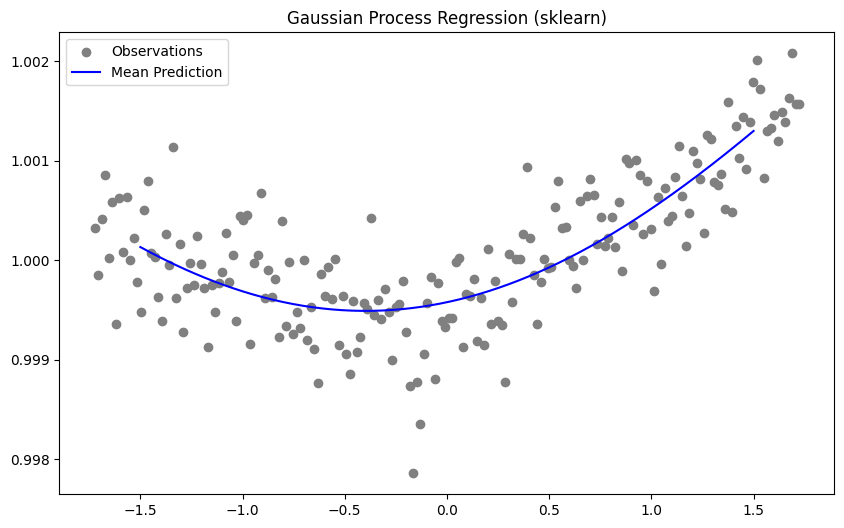

In [10]:
# 核函数
kernel = RBF(length_scale=1.0, length_scale_bounds=(0.1, 10.0)) + WhiteKernel(noise_level=0.1)
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

# 模型拟合
gpr.fit(X, y)

# 预测
y_pred, y_std = gpr.predict(X_pred, return_std=True)

# 可视化
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color="gray", label="Observations")
plt.plot(X_pred, y_pred, color="blue", label="Mean Prediction")
# plt.fill_between(X_pred.ravel(), y_pred - 2 * y_std, y_pred + 2 * y_std, alpha=0.2, color="blue", label="Confidence Interval")
plt.legend()
plt.title("Gaussian Process Regression (sklearn)")
plt.show()